# Dataset & Noise

First we observe the visual feature of our dataset and the effect of our noise on the dataset

ORL Dataset


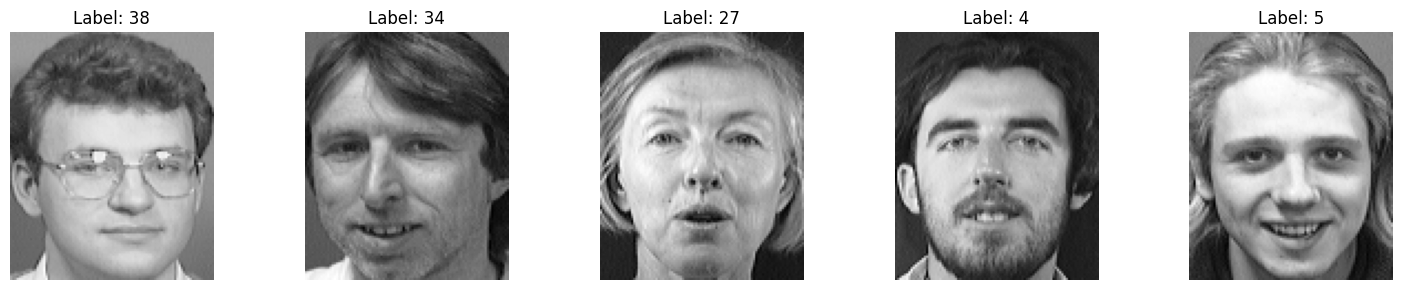

ORL Dataset (With Noise)


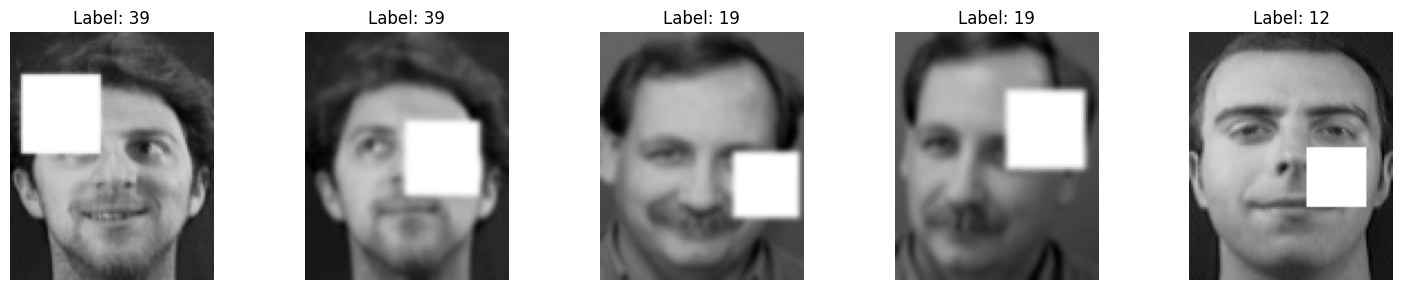

YaleB Dataset


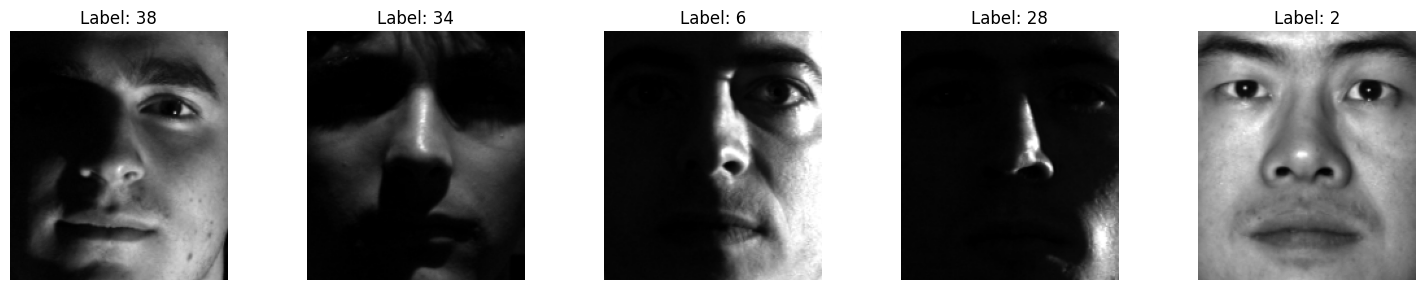

YaleB Dataset(With Noise)


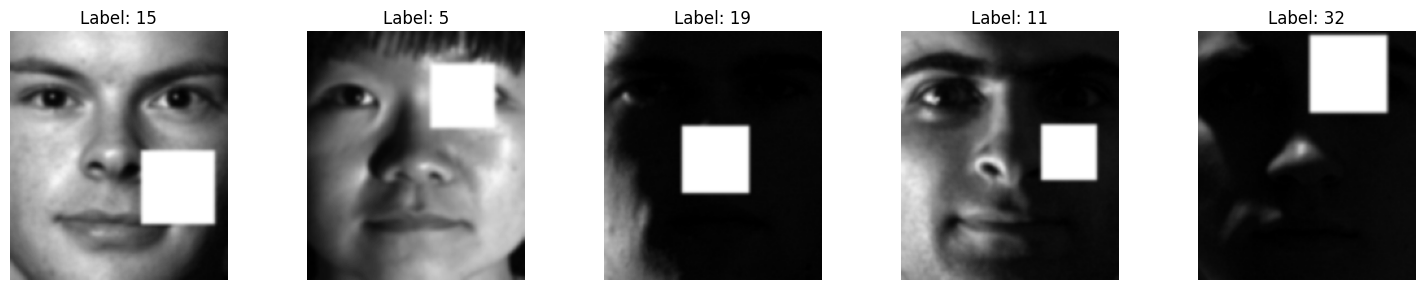

In [1]:
from preprocessing.noise import BlockNoise, BlurNoise
from utils.visualization import sample_and_plot_images
from preprocessing.load_data import load_image_data

block_noise_p100 = BlockNoise(mean=0.35, std=0.05, prob=1)
blur_noise_p100 = BlurNoise(mean=1, std=0.5, prob=1)

_, image_labels, image_objects = load_image_data('./data/ORL', noise_functions=[])
print("ORL Dataset")
sample_and_plot_images(image_objects, image_labels)

_, image_labels, image_objects = load_image_data('./data/ORL', noise_functions=[block_noise_p100, blur_noise_p100])
print("ORL Dataset (With Noise)")
sample_and_plot_images(image_objects, image_labels)

_, image_labels, image_objects = load_image_data('./data/CroppedYaleB', noise_functions=[])
print("YaleB Dataset")
sample_and_plot_images(image_objects, image_labels)

_, image_labels, image_objects = load_image_data('./data/CroppedYaleB', noise_functions=[block_noise_p100, blur_noise_p100])
print("YaleB Dataset(With Noise)")
sample_and_plot_images(image_objects, image_labels)


# Set up Experiment
Set up the experiment with the following parameters options, with each combination we will run 5 experiments.
* nmf: the algorithm used
* datatset: the dataset used
* noises: the noise functions applied

In [2]:
from typing import Optional
from dataclasses import dataclass, asdict
from utils.visualization import plot_reconstructed_images

from preprocessing.noise import BlockNoise, BlurNoise
from preprocessing.custom_preprocess import ImagePreprocessor
from preprocessing.load_data import load_image_data
from algorithms.gpu import MultiplicativeUpdateNMF, RobustNMF, SparseNMF

@dataclass
class ExperimentParam:
    nmf: str # 'multiplicative_update' | 'robust' | 'sparse'
    dataset: str # 'yaleB' | 'orl'
    noises: list # ['block_noise', 'blur_noise']
    noise_p: float # noise probability
    hyper_param: Optional[dict] # hyper-parameters for the algorithm

class Experiment:
    def __init__(self, param: ExperimentParam):
        self.param = param


    def run(self, run_name: str):
        # set up
        preprocessor = ImagePreprocessor(max_size=2_400)
        block_noise = BlockNoise(mean=0.28, std=0.1, prob=0.6)
        blur_noise = BlurNoise(mean=2.8, std=0.5, prob=0.6)

        # noise
        noises = []
        if "block_noise" in self.param.noises:
            block_noise = BlockNoise(mean=0.35, std=0.05, prob=self.param.noise_p)
            noises.append(block_noise)
        if "blur_noise" in self.param.noises:
            blur_noise = BlurNoise(mean=1, std=0.5, prob=self.param.noise_p)
            noises.append(blur_noise)

        # load data
        data_path = './data/CroppedYaleB' if self.param.dataset == 'yaleB' else './data/ORL'
        image_data, image_labels, image_objects = load_image_data(
            data_path,
            preprocess_function=preprocessor.preprocess,
            noise_functions=noises,
            data_fraction=0.9,
        )

        # run NMF algorithms
        if self.param.nmf == 'multiplicative_update':
            nmf_object = MultiplicativeUpdateNMF(
                V=image_data.T,
                num_features=50,
                max_iters=5000,
            )
            nmf_object.fit(
                plot_metrics=False,
                use_tqdm=True,
                early_stop=True,
                patience=300,
                tol=1e-4,
            )
        elif self.param.nmf == 'robust':
            nmf_object = RobustNMF(
                V=image_data.T,
                num_features=50,
                max_iters=8_000,
                lambda_param=self.param.hyper_param['lambda'],
                start_learning_rate=0.0003,
                end_learning_rate=0.000005,
            )
            nmf_object.fit(
                plot_metrics=False,
                use_tqdm=True,
                early_stop=True,
                patience=300,
                tol=1e-4,
            )
        elif self.param.nmf == 'sparse':
            nmf_object = SparseNMF(
                V=image_data.T,
                num_features=50,
                max_iters=5000,
                alpha=self.param.hyper_param['alpha'],
                beta=self.param.hyper_param['beta']
            )
            nmf_object.fit(
                plot_metrics=False,
                use_tqdm=True,
                early_stop=True,
                patience=300,
                tol=1e-4,
            )
        else:
            raise ValueError("nmf must be one of 'multiplicative_update', 'robust', 'sparse'")

        

        # collect metrics
        metrics = nmf_object.evaluate(image_labels)
        reconstructed_images_path = plot_reconstructed_images(nmf_object.get_reconstruction().T, image_objects, preprocessor, save_only=True, name=run_name, num_samples=10)

        return {
            "name": run_name,
            "param": asdict(self.param),
            "metrics": metrics,
            "reconstructed_images_path": reconstructed_images_path,
        }



# Run Experiments

In [3]:
nmfs = ['robust', 'sparse', 'multiplicative_update']
datasets = ['yaleB', 'orl']
noise_ps = [0, 0.15, 0.4, 0.7, 1]
hyper_params = {
    'robust': [
        {'lambda': 0.5},
        {'lambda': 0.8},
        {'lambda': 1},
    ],
    'sparse': [
        {'alpha': 0.5, 'beta': 0.5},
        {'alpha': 0.8, 'beta': 0.8},
        {'alpha': 1, 'beta': 1},
    ],
}

results = []
for nmf in nmfs:
    for dataset in datasets:
        for noise_p in noise_ps:
            for hyper_param in hyper_params[nmf]:
                param = ExperimentParam(
                    nmf=nmf,
                    dataset=dataset,
                    noises=['block_noise', 'blur_noise'],
                    noise_p=noise_p,
                    hyper_param=hyper_param,
                )

                print("\n\n=====================================")
                print("Running experiment with param:")
                print(param)

                for i in range(5):
                    experiment = Experiment(param)
                    result = experiment.run(f"{nmf}_{dataset}_{noise_p}_{hyper_param}_{i}")
                    results.append(result)

TypeError: __init__() missing 1 required positional argument: 'noise_p'

In [ ]:
import pandas as pd
# Convert to DataFrame
df = pd.DataFrame(results)

# If you want to flatten the dictionaries inside columns 'param' and 'metrics' to separate columns:
df = pd.concat([df.drop(['param', 'metrics'], axis=1),
                df['param'].apply(pd.Series),
                df['metrics'].apply(pd.Series)], axis=1)

df.to_csv("results.csv", index=False)

C:\Users\eason\AppData\Local\Temp\ipykernel_21208\1726693348.py:7: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  df['param'].apply(pd.Series),
C:\Users\eason\AppData\Local\Temp\ipykernel_21208\1726693348.py:8: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  df['metrics'].apply(pd.Series)], axis=1)
